In [7]:
import numpy as np
from pathlib import Path
import pandas as pd
from sys import platform
import os
import matplotlib.pyplot as plt
%matplotlib inline
%load_ext autoreload
%autoreload 2
import seaborn as sns
sns.set(font_scale=2, style='ticks')
# from activity_swim_bout import *
from utils import cont_mode
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from utils import *
from scipy.signal import find_peaks
import warnings
warnings.filterwarnings('ignore')
from scipy.stats import sem

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [11]:
dir_folder = '/nrs/ahrens/Ziqiang/Takashi_DRN_project/ProcessedData/'
vol_file = Path('../Analysis/depreciated/analysis_sections_ablation_gain_update.csv')
dat_xls_file = pd.read_csv(vol_file, index_col=0)
dat_xls_file['folder'] = dat_xls_file['folder'].apply(lambda x: f'{x:0>8}')
t_pre = 100 # time window pre-swim
t_post = 350 # time window post-swim

In [16]:
def search_paired_data(row, flist):
    if 'before' not in row['fish']:
        return False
    fish = row['fish'][:-6]
    for _, row_ in flist.iterrows():
        if row_['folder'] != row['folder']:
            continue
        if row_['fish'] == fish+'after':
            return True
    return False

## Gain adapation

In [22]:
def gain_trace(row):
    folder = row['folder']
    fish = row['fish']    
    _ = np.load(f'../Analysis/swim_power/{folder}_{fish}_swim_dat.npz')
    swim_starts = _['swim_starts']
    swim_ends = _['swim_ends']
    r_swim = _['r_swim']
    l_swim = _['l_swim']
    visu = _['visu']
    task_period = _['task_period']
    swim_task_index = _['swim_task_index']
    _ = np.load(f'../Analysis/swim_voltr/{folder}_{fish}_swim_voltr_ablt_dat.npz')
    sub_swim = _['sub_swim']
    spk_swim = _['spk_swim']
    sub_list_ = spk_swim[:, :, t_pre:-60].mean(axis=-1).T
    valid_trial = np.isnan(sub_list_.sum(axis=-1))
    task_period[valid_trial] = np.inf
    lda = LDA()
    lda.fit(sub_list_[task_period<3, :], task_period[task_period<3])
    lad_score = lda.score(sub_list_[task_period<3, :], task_period[task_period<3])
    if lad_score<0.7:
        return None, None, None, None
    coef_ = lda.coef_
    coef_ = coef_/np.linalg.norm(coef_)
    
    tmin = -1
    tmax = 19
    fish = fish[:-6]
    
    # ======================== before
    dat_dir = dir_folder+f'{folder}/{fish}before/Data/'
    swim_dir = dir_folder+f'{folder}/{fish}before/swim/'
    dff = np.load(dat_dir+'Voltr_spikes.npz')['voltrs']
    dff = dff - np.nanmedian(dff, axis=1, keepdims=True)
    spk = np.load(dat_dir+'Voltr_spikes.npz')['spk']
    num_cell = spk.shape[0]
    spk = np.r_['-1', np.zeros((num_cell, 600)), spk]
    frame_stimParams = np.load(swim_dir+'frame_stimParams.npy')
    frame_swim_tcourse = np.load(swim_dir+'frame_swim_tcourse.npy')
    
    k_ = boxcarKernel(1201)
    spk_smooth = spk.copy()
    for ncell in range(spk_smooth.shape[0]):
        spk_smooth[ncell] = smooth(spk[ncell], k_)*300
    pop_act = spk_smooth.T.dot(coef_.T)
    pop_act = pop_act.ravel()

    n_task = task_period.max().astype('int')
    swim_task_index_ = (swim_task_index-1)%n_task+1
    swim_bout_index_task = np.zeros(len(swim_task_index_)).astype('int')
    swim_bout_index_task[0] = 1
    for n_bout in range(len(swim_task_index_)-1):
        if swim_task_index_[n_bout] == swim_task_index_[n_bout-1]:
            swim_bout_index_task[n_bout] = swim_bout_index_task[n_bout-1]+1
        else:
            swim_bout_index_task[n_bout] = 1       
    low_on = np.where((frame_stimParams[2][:-1]==frame_stimParams[2].max()) & (frame_stimParams[2][1:]==1))[0]
    lda_low = np.zeros((len(low_on), (tmax-tmin)*300))
    lda_low[:] = np.nan
    for n in range(len(low_on)-1):
        next_list = np.where(frame_stimParams[2][low_on[n]+1:]!=1)[0]
        if len(next_list)>0:
            tmax_ = min([next_list[0], tmax*300])
            lda_low[n, :tmax_-tmin*300] = pop_act[low_on[n]+tmin*300:low_on[n]+tmax_]

    high_on = np.where((frame_stimParams[2][:-1]==1) & (frame_stimParams[2][1:]==2))[0]
    lda_high = np.zeros((len(high_on), (tmax-tmin)*300))
    lda_high[:] = np.nan
    for n in range(len(high_on)):
        next_list = np.where(frame_stimParams[2][high_on[n]+1:]!=2)[0]
        if len(next_list)>0:
            tmax_ = min([next_list[0], tmax*300])
            lda_high[n, :tmax_-tmin*300] = pop_act[high_on[n]+tmin*300:high_on[n]+tmax_]
    
    # ======================== after
    dat_dir = dir_folder+f'{folder}/{fish}after/Data/'
    swim_dir = dir_folder+f'{folder}/{fish}after/swim/'
    dff = np.load(dat_dir+'Voltr_spikes.npz')['voltrs']
    dff = dff - np.nanmedian(dff, axis=1, keepdims=True)
    spk = np.load(dat_dir+'Voltr_spikes.npz')['spk']
    num_cell = spk.shape[0]
    spk = np.r_['-1', np.zeros((num_cell, 600)), spk]
    frame_stimParams = np.load(swim_dir+'frame_stimParams.npy')
    frame_swim_tcourse = np.load(swim_dir+'frame_swim_tcourse.npy')
    
    k_ = boxcarKernel(1201)
    spk_smooth = spk.copy()
    for ncell in range(spk_smooth.shape[0]):
        spk_smooth[ncell] = smooth(spk[ncell], k_)*300
    pop_act = spk_smooth.T.dot(coef_.T)
    pop_act = pop_act.ravel()

    n_task = task_period.max().astype('int')
    swim_task_index_ = (swim_task_index-1)%n_task+1
    swim_bout_index_task = np.zeros(len(swim_task_index_)).astype('int')
    swim_bout_index_task[0] = 1
    for n_bout in range(len(swim_task_index_)-1):
        if swim_task_index_[n_bout] == swim_task_index_[n_bout-1]:
            swim_bout_index_task[n_bout] = swim_bout_index_task[n_bout-1]+1
        else:
            swim_bout_index_task[n_bout] = 1       
    low_on = np.where((frame_stimParams[2][:-1]==frame_stimParams[2].max()) & (frame_stimParams[2][1:]==1))[0]
    lda_low_ = np.zeros((len(low_on), (tmax-tmin)*300))
    lda_low_[:] = np.nan
    for n in range(len(low_on)-1):
        next_list = np.where(frame_stimParams[2][low_on[n]+1:]!=1)[0]
        if len(next_list)>0:
            tmax_ = min([next_list[0], tmax*300])
            lda_low_[n, :tmax_-tmin*300] = pop_act[low_on[n]+tmin*300:low_on[n]+tmax_]

    high_on = np.where((frame_stimParams[2][:-1]==1) & (frame_stimParams[2][1:]==2))[0]
    lda_high_ = np.zeros((len(high_on), (tmax-tmin)*300))
    lda_high_[:] = np.nan
    for n in range(len(high_on)):
        next_list = np.where(frame_stimParams[2][high_on[n]+1:]!=2)[0]
        if len(next_list)>0:
            tmax_ = min([next_list[0], tmax*300])
            lda_high_[n, :tmax_-tmin*300] = pop_act[high_on[n]+tmin*300:high_on[n]+tmax_]
            
    return np.nanmean(lda_low, axis=0), np.nanmean(lda_high, axis=0), np.nanmean(lda_low_, axis=0), np.nanmean(lda_high_, axis=0)

In [38]:
low_list = []
high_list = []
low_list_ = []
high_list_ = []
fish_id = []
for _, row in dat_xls_file.iterrows():
    if search_paired_data(row, dat_xls_file):
        ave_low, ave_high, ave_low_, ave_high_ = gain_trace(row)
        if ave_low is None:
            continue
        low_list.append(ave_low)
        high_list.append(ave_high)
        low_list_.append(ave_low_)
        high_list_.append(ave_high_)
        fish_id.append(row['folder']+row['fish'])

In [39]:
lda_low = np.array(low_list)
lda_high = np.array(high_list)
valid = (lda_high - lda_low)[:, :-200].mean(axis=-1)>0.2
lda_low_ = np.array(low_list_)
lda_high_ = np.array(high_list_)

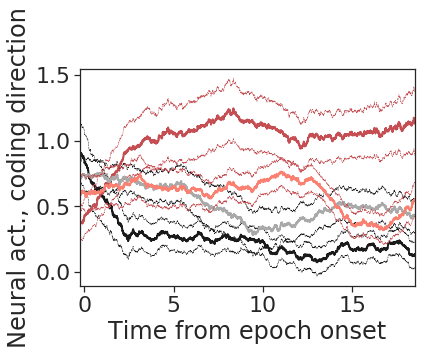

In [40]:
# lda_low = lda_low/lda_high.max(axis=-1, keepdims=True)
# lda_high = lda_high/lda_high.max(axis=-1, keepdims=True)

tmin=-1
tmax=19

# ave_ = np.percentile(lda_low, 90, axis=0)
ave_ = np.mean(lda_low[valid], axis=0)
sem_ = sem(lda_low[valid], axis=0)/3
# plt.plot(np.arange(tmin, tmax, 1/300), lda_low.T, '-k', lw=0.5, label='low gain')
plt.plot(np.arange(tmin, tmax, 1/300), ave_, '-k', lw=2, label='low gain')
plt.plot(np.arange(tmin, tmax, 1/300), ave_+sem_, '--k', lw=0.5)
plt.plot(np.arange(tmin, tmax, 1/300), ave_-sem_, '--k', lw=0.5)

# ave_ = np.percentile(lda_high, 90, axis=0)
ave_ = np.mean(lda_high[valid], axis=0)
sem_ = sem(lda_high[valid], axis=0)/3
# plt.plot(np.arange(tmin, tmax, 1/300), lda_high.T, '-r', lw=0.5, label='high gain')
plt.plot(np.arange(tmin, tmax, 1/300), ave_, '-r', lw=2, label='high gain')
plt.plot(np.arange(tmin, tmax, 1/300), ave_+sem_, '--r', lw=0.5)
plt.plot(np.arange(tmin, tmax, 1/300), ave_-sem_, '--r', lw=0.5)
plt.xlim([-0.25, tmax-0.5])   


# ave_ = np.percentile(lda_low, 90, axis=0)
ave_ = np.mean(lda_low_[valid], axis=0)
sem_ = sem(lda_low_[valid], axis=0)/3
# plt.plot(np.arange(tmin, tmax, 1/300), lda_low.T, '-k', lw=0.5, label='low gain')
plt.plot(np.arange(tmin, tmax, 1/300), ave_, '-', color='darkgray', lw=2, label='low gain')
plt.plot(np.arange(tmin, tmax, 1/300), ave_+sem_, '--k', lw=0.5)
plt.plot(np.arange(tmin, tmax, 1/300), ave_-sem_, '--k', lw=0.5)

# ave_ = np.percentile(lda_high, 90, axis=0)
ave_ = np.mean(lda_high_[valid], axis=0)
sem_ = sem(lda_high_[valid], axis=0)/3
# plt.plot(np.arange(tmin, tmax, 1/300), lda_high.T, '-r', lw=0.5, label='high gain')
plt.plot(np.arange(tmin, tmax, 1/300), ave_, '-', color='salmon', lw=2, label='high gain')
plt.plot(np.arange(tmin, tmax, 1/300), ave_+sem_, '--r', lw=0.5)
plt.plot(np.arange(tmin, tmax, 1/300), ave_-sem_, '--r', lw=0.5)
plt.xlim([-0.25, tmax-0.5])   

plt.xlabel('Time from epoch onset')
plt.ylabel('Neural act., coding direction')    
plt.show()

In [41]:
fish_id

['04032019Fish1-plane1-before',
 '04032019Fish1-plane2-before',
 '04112019Fish3-plane#1-before',
 '04112019Fish3-plane#2-before',
 '04112019Fish4-plane#2-before',
 '04112019Fish4-plane#3-before',
 '04112019Fish5-plane#1-before',
 '04112019Fish5-plane#2-before']